## All Imports

In [8]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split as tts 
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt 
# import models as md 
# from data_handler import data_loader_data_batches as dh 
import torch.optim as optim 

## Loading the Data and Creating them into Batches

In [2]:
def data_loader_data_batches(path, batch_size): 
    data = pd.read_csv(path)
    data.drop(['date'], axis=1, inplace=True)

    y = data['DAX'].values.astype(np.float32)                  # .values returns numpy array 
    x = data.drop(['DAX'], axis=1).values.astype(np.float32) 

    x, y = torch.from_numpy(x).float(), torch.from_numpy(y).float()
    x_train, x_test, y_train, y_test = tts(x, y, test_size=0.3)

    num_batches_train, num_batches_test  = x_train.shape[0] // batch_size,  x_test.shape[0] // batch_size

    indexes_train, indexes_test  = np.random.permutation(x_train.shape[0]),  np.random.permutation(x_test.shape[0])          # Shuffles the index of the data 
    
    x_train, y_train = x_train[indexes_train],  y_train[indexes_train]    
    x_test, y_test = x_test[indexes_test], y_test[indexes_test]

    x_train = x_train[ :batch_size * num_batches_train].reshape(num_batches_train, batch_size, x_train.shape[1])
    y_train = y_train[ :batch_size * num_batches_train].reshape(num_batches_train, batch_size, 1)

    x_test = x_test[ :batch_size * num_batches_test].reshape(num_batches_test, batch_size, x_test.shape[1])
    y_test = y_test[ :batch_size * num_batches_test].reshape(num_batches_test, batch_size, 1)

    return x_train, x_test, y_train, y_test

In [3]:
x_train, x_test, y_train, y_test = data_loader_data_batches('data/turkish_stocks.csv', 100) 

## Build Model

In [5]:
class RegressionModel_1(nn.Module):
     def __init__(self, input):
          super(RegressionModel_1, self).__init__()
          self.first_later = nn.Linear(input, 64)
          self.second_layer = nn.Linear(64, 64)
          self.third_layer = nn.Linear(64, 32)
          self.last_layer = nn.Linear(32, 1)
          self.relu = nn.ReLU()

     def forward(self, x):
          x = self.relu( self.first_later(x) )
          x = self.relu( self.second_layer(x) )
          x = self.relu( self.third_layer(x) )
          x = self.last_layer(x)

          return x 


class RegressionModel_2(nn.Module):
     def __init__(self, input):
          super(RegressionModel_2, self).__init__()
          self.first_later = nn.Linear(input, 16)
          self.second_layer = nn.Linear(16, 16)
          self.third_layer = nn.Linear(16, 16)
          self.last_layer = nn.Linear(16, 1)
          self.relu = nn.ReLU()

     def forward(self, x):
          x = self.relu( self.first_later(x) )
          x = self.relu( self.second_layer(x) )
          x = self.relu( self.third_layer(x) )
          x = self.last_layer(x)

          return x 

## Instantiate The Model

In [9]:
model = RegressionModel_2(8)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()
epochs = 30

## Train the Model

In [11]:
all_train_losses, all_test_losses = [], []

for epoch in range(epochs):
     x_train_batches, x_test_batches, y_train_batches, y_test_batches = data_loader_data_batches(path='data/turkish_stocks.csv', batch_size=50)
     running_loss_train, running_loss_test = 0, 0
     for x_train, y_train in zip(x_train_batches, y_train_batches):
          optimizer.zero_grad()
          train_prediction = model.forward(x_train)
          train_loss = criterion(train_prediction, y_train)
          train_loss.backward()
          optimizer.step()
          running_loss_train += train_loss.item()
     
     average_loss_train = running_loss_train/len(x_train_batches)
     all_train_losses.append(average_loss_train)

     model.eval()
     with torch.no_grad():
          for x_test, y_test in zip(x_test_batches, y_test_batches): 
               test_prediction = model.forward(x_test)
               test_loss = criterion(test_prediction, y_test)
               running_loss_test += test_loss.item()

          average_loss_test = running_loss_test/len(x_test_batches)
          all_test_losses.append(average_loss_test)
     model.train()

     print(f'epoch {epoch+1:2}/{epochs}  |  Train Loss  : {average_loss_train:.8f}    |  Test Loss  : {average_loss_test:.8f}')

model_data = { "model_state": model.state_dict(), "input_size": 8}

epoch  1/30  |  Train Loss  : 0.00725087    |  Test Loss  : 0.00198036
epoch  2/30  |  Train Loss  : 0.00280710    |  Test Loss  : 0.00099846
epoch  3/30  |  Train Loss  : 0.00042856    |  Test Loss  : 0.00075790
epoch  4/30  |  Train Loss  : 0.00080535    |  Test Loss  : 0.00027783
epoch  5/30  |  Train Loss  : 0.00025703    |  Test Loss  : 0.00033620
epoch  6/30  |  Train Loss  : 0.00030977    |  Test Loss  : 0.00021107
epoch  7/30  |  Train Loss  : 0.00017510    |  Test Loss  : 0.00024648
epoch  8/30  |  Train Loss  : 0.00020537    |  Test Loss  : 0.00013843
epoch  9/30  |  Train Loss  : 0.00015281    |  Test Loss  : 0.00018766
epoch 10/30  |  Train Loss  : 0.00015657    |  Test Loss  : 0.00011443
epoch 11/30  |  Train Loss  : 0.00016750    |  Test Loss  : 0.00008047
epoch 12/30  |  Train Loss  : 0.00013635    |  Test Loss  : 0.00011424
epoch 13/30  |  Train Loss  : 0.00011366    |  Test Loss  : 0.00011049
epoch 14/30  |  Train Loss  : 0.00010208    |  Test Loss  : 0.00011743
epoch 

## Save the Model

In [12]:
model_data = { "model_state": model.state_dict(), "input_size": 8}
torch.save(model_data, 'trained_model')

## Plot the Results

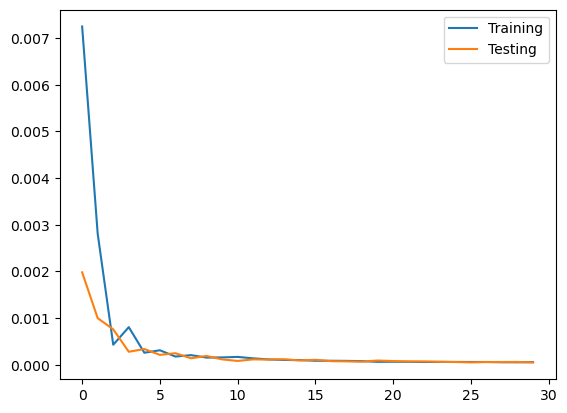

In [13]:
plt.plot(all_train_losses, label='Training')
plt.plot(all_test_losses,  label='Testing')
plt.legend()
plt.show()

## Making Prediction

## Load Trained Model First

In [14]:
import torch
import numpy as np 

trained_model = torch.load('trained_model')
model_state = trained_model['model_state']

model = RegressionModel_2(8)
model.load_state_dict(model_state)

<All keys matched successfully>

## Create Dummy Data

In [15]:
features = np.array([0.035753708, 0.038376187, -0.004679315, 0.003894376, 0, 0.031190229,0.012698039, 0.028524462]).astype(np.float32)
features = torch.from_numpy(features)

input_features = torch.tensor([0.035753708, 0.038376187, -0.004679315, 0.003894376, 0, 0.031190229,0.012698039, 0.028524462])
target = 0.002193419

## Make Predictions

In [16]:
prediction = model.forward(features)
print('Prediction : ', prediction)

Prediction :  tensor([0.0176], grad_fn=<AddBackward0>)


In [17]:
prediction = model.forward(input_features)
print('Prediction : ', prediction)

Prediction :  tensor([0.0176], grad_fn=<AddBackward0>)
